# Automatic Extraction of Fine Structural Information in ARPES by Multi-Stage Clustering Algorithm

Lingzhu Bian, Chen Liu, Zhen Zhang, Yingke Huang, Xinyu Pan, Yi Zhang, Jiaou Wang, Zhesheng Chen, Yuhui Dong  

Correspondence should be addressed to Lingzhu Bian (bianlz@ihep.ac.cn)

# iEDCs K-means clustering on the data of MoS2 

# Part 1: Data Loading and pre-processing

 ### - Module Setting

In [1]:
import warnings
import os
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
import math
warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '8'
np.set_printoptions(threshold=np.inf)

### - Plot Setting

In [2]:
#col_arr = ["gray","orange","brown","blue","purple", "violet"]
col_arr = ["dimgray", "burlywood", "sandybrown", "lightskyblue", "mediumorchid", "blueviolet"]
fontsize1=40
fontsize2=35
markershape="o"
markersize=25
plt.rcParams['font.family'] = 'Times New Roman'

### - Load data and initial settings

In [3]:
file = h5py.File("RealData.h5", 'r')
dataset = file['data']  
mapdata = dataset[:]  


# Size
xn = np.shape(mapdata)[0] # x-axis  
yn = np.shape(mapdata)[1] # y-axis
en = np.shape(mapdata)[2] # Energies
an = np.shape(mapdata)[3] # Angles
pn = xn * yn

# X axis
x_ini = 75
x_end = 165
xw = x_end-x_ini # Width 
dx = 1 # Step

# Y axis
y_ini = 175
y_end = 256
yw =y_end-y_ini  # Width
dy = 1.0125 # Step

# Mapping axes will be rescaled w.r.t. center of the image
k = 0
xpos = np.zeros(xn*yn)
ypos = np.zeros(xn*yn)
for i in range(xn):
    for j in range(yn):
        xpos[k] = -xw/2 + i*dx 
        ypos[k] = -yw/2 + j*dy 
        k += 1
    
# Energy/Angle axis
eng_ini = 84.9599
eng_end = 99.9160
engbins = 889

ang_ini = -20.0431     
ang_end = 6.6810
angbins = 32

eng = np.zeros(engbins)
for i in range(engbins):
    eng[i]=eng_ini+(eng_end-eng_ini)/(engbins-1)*i
ang = np.zeros(angbins)
for i in range(angbins):
    ang[i]=ang_ini+(ang_end-ang_ini)/(angbins-1)*i



print("Load File:", "RealData.h5")
print("\r")
print("---Data Size---")
print("Map Axis 1 :", xn)
print("Map Axis 2 :", yn)
print("Energy :", en)
print("Angle :", an)
print("Energy (start, end):", eng_ini, eng_end)
print("Angle (start, end):", ang_ini, ang_end)
print("eng:", eng)
print("ang:", ang)
print("\r")

Load File: RealData.h5

---Data Size---
Map Axis 1 : 91
Map Axis 2 : 81
Energy : 889
Angle : 32
Energy (start, end): 84.9599 99.916
Angle (start, end): -20.0431 6.681
eng: [84.9599     84.97674245 84.99358491 85.01042736 85.02726982 85.04411227
 85.06095473 85.07779718 85.09463964 85.11148209 85.12832455 85.145167
 85.16200946 85.17885191 85.19569437 85.21253682 85.22937928 85.24622173
 85.26306419 85.27990664 85.2967491  85.31359155 85.33043401 85.34727646
 85.36411892 85.38096137 85.39780383 85.41464628 85.43148874 85.44833119
 85.46517365 85.4820161  85.49885856 85.51570101 85.53254347 85.54938592
 85.56622838 85.58307083 85.59991329 85.61675574 85.6335982  85.65044065
 85.66728311 85.68412556 85.70096802 85.71781047 85.73465293 85.75149538
 85.76833784 85.78518029 85.80202275 85.8188652  85.83570766 85.85255011
 85.86939257 85.88623502 85.90307748 85.91991993 85.93676239 85.95360484
 85.9704473  85.98728975 86.00413221 86.02097466 86.03781712 86.05465957
 86.07150203 86.08834448 86

### - Truth Table

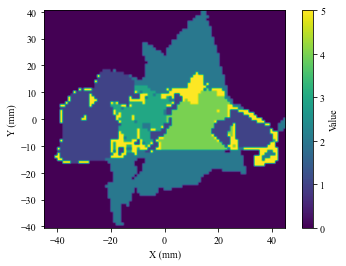

In [4]:
file_TT = h5py.File("truth_table.h5", 'r')
dataset_TT = file_TT['s2']  
TruthTable = dataset_TT[:]  
#switch BN and MoS2-Au
TruthTable = np.where(TruthTable == 2, 1, np.where(TruthTable == 1, 2, TruthTable))
#set all uncertain points to 5
non_integer_mask = (TruthTable % 1 != 0)
TruthTable = np.where(non_integer_mask, 5, TruthTable)


fig, ax = plt.subplots()
im = ax.imshow(TruthTable.T, extent = [-xw/2, xw/2, -yw/2, yw/2], origin='lower')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

cbar = plt.colorbar(im)
cbar.set_label('Value')
plt.show()

### - Flatten 4D map to 2D image (iEDCs) 

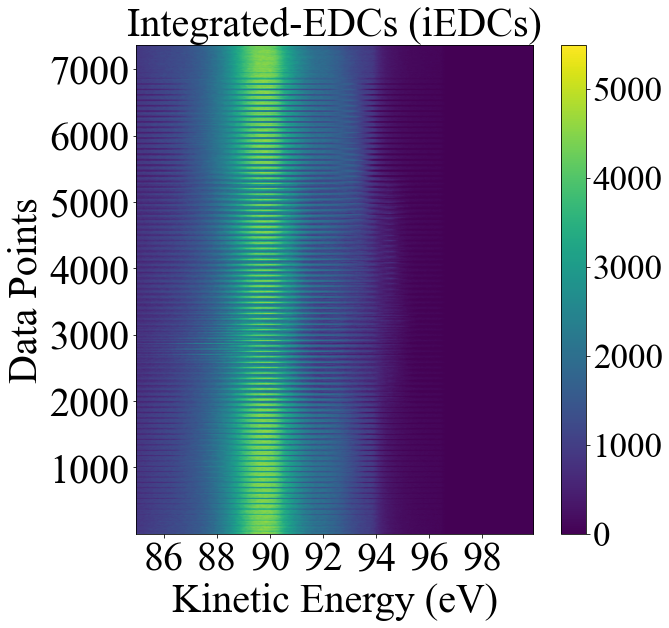

In [5]:
iEDCs = np.sum(mapdata, axis = 3).reshape(xn*yn, en) 
np.savetxt('iEDCs.txt', iEDCs)

fig = plt.figure(figsize=(10,9))
plt.rcParams['font.family'] = 'Times New Roman'
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs, extent = [eng_ini, eng_end, 1, xn*yn], aspect = 0.0025)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("Integrated-EDCs (iEDCs)",fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
fig = plt.gcf()
plt.show()

# Part 2: Perform iEDCs K-means clustering 

## (2-i) Select iEDCs as the clustering input

In [6]:
#Select iEDCs as the clustering input
targetMap = iEDCs
slice_axis = eng
sn = np.shape(eng)[0]

## (2-ii) Get the result of n=3

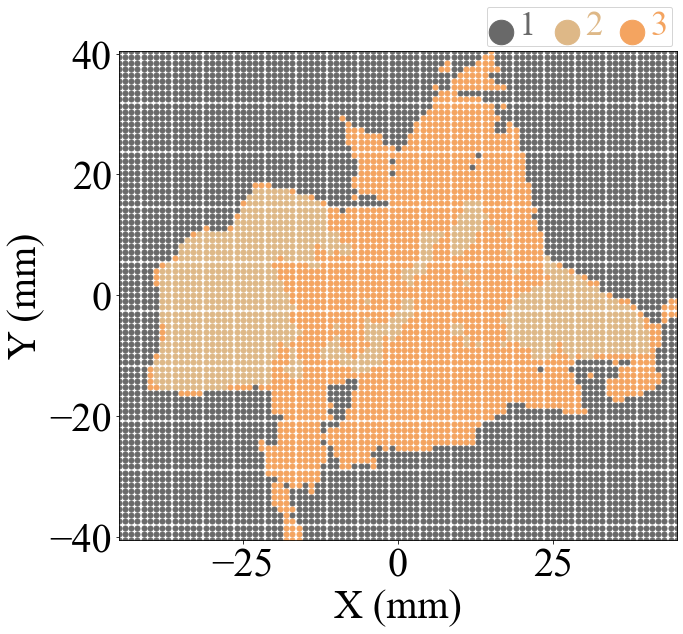

In [7]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=100)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
km_results_of_each_cluster = np.zeros((nk,pn))

label_mapping = {2: 1, 1: 2, 0:0}
km_results = np.array([label_mapping[label] for label in km_results])
resultsfile = f'kmresults_{nk}.npy'
np.save(resultsfile,km_results)
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
x_nk3 = []
y_nk3 = []
for i in range(nk):
    x = []
    y = []
    for j in range(pn):
        curcln = km_results[j]
        if i == curcln:
            km_results_of_each_cluster[i][j] = i
            x = np.append(x, xpos[j])
            y = np.append(y, ypos[j])
        if j == pn-1:
            ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i], label=str(i+1))
            x_nk3.append(x)
            y_nk3.append(y)
            
ax.set_xlim(-xw/2, xw/2)  
ax.set_ylim(-yw/2, yw/2) 
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

# Legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
i = 0
for text in legend.get_texts():
    text.set_fontsize(fontsize2)
    text.set_fontname('Times New Roman')
    text.set_color(col_arr[i])
    i = i+1
i = 0
for handle in legend.legendHandles:
    handle.set_color(col_arr[i])  
    handle.set_sizes([600])   
    i = i+1

plt.show()

## Part 3: Self-defined functions for plotting and calculating performance metrics

In [8]:
def clustering_and_visualization(nk,data,x_chosen,y_chosen, km_results_of_chosen_cluster, label_mapping):
    km = KMeans(n_clusters=nk, n_init=10, random_state=100)
    km_model = km.fit(data)
    km_results_chosen = km_model.labels_
    if label_mapping is not None:
        label_mapping = label_mapping
        km_results_chosen = np.array([label_mapping[label] for label in km_results_chosen])
        
    pn_chosen = len(km_results_chosen) 
    nonzero_indices = np.nonzero(km_results_of_chosen_cluster)[0]
    new_km_results_of_chosen_cluster = np.zeros((nk,pn))
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    x_list = []
    y_list = []
    for i in range(nk):
        x = []
        y = []
        for j in range(len(km_results_chosen)):
            curcln = km_results_chosen[j]
            if i == curcln:
                indice = nonzero_indices[j]
                new_km_results_of_chosen_cluster[i][indice] = i+2
                x = np.append(x, x_chosen[j])
                y = np.append(y, y_chosen[j])
            if j == pn_chosen-1:
                ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i],label=str(i+1))
                x_list.append(x)
                y_list.append(y)
    ax.set_xlim(-xw/2, xw/2)  
    ax.set_ylim(-yw/2, yw/2)  
    ax.tick_params(axis='both', which='major', labelsize=fontsize1)  
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
    i = 0
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')
        text.set_color(col_arr[i])
        i = i+1
    i = 0
    for handle in legend.legendHandles:
        handle.set_color(col_arr[i])  
        handle.set_sizes([600])   
        i = i+1
    plt.show()
    
    return km_results_chosen,fig,x_list, y_list, new_km_results_of_chosen_cluster

In [9]:
def clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster):
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(x_of_each_cluster)):
        x = x_of_each_cluster[i]
        y = y_of_each_cluster[i]
        ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i],label=str(i+1))
    ax.set_xlim(-xw/2, xw/2)  
    ax.set_ylim(-yw/2, yw/2)  
    ax.tick_params(axis='both', which='major', labelsize=fontsize1)  
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    #blank_handle = plt.Line2D([], [], color='none', label='Clusters: ')
    handles, labels = ax.get_legend_handles_labels()
    #handles.insert(0, blank_handle)
    #labels.insert(0, 'Clusters: ')
    legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=len(x_of_each_cluster)+1)
     
    i = 0
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')
        text.set_color(col_arr[i])
        i = i+1
    i = 0
    for handle in legend.legendHandles:
        handle.set_color(col_arr[i])  
        handle.set_sizes([600])   
        i = i+1
    plt.show()
    
    return fig

In [10]:
def calculate_accuracy(comment, label_all, label_mapping):
    fig = plt.figure(figsize=(10,9))
    if label_mapping is not None:
        label_all = np.array([label_mapping[label] for label in label_all])
    plt.imshow(label_all.reshape(91,81).T, origin='lower')
    plt.colorbar()
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.show()

    ## metrics of performance     
    calculate_metrics(None,comment, TruthTable, label_all)

In [11]:
def calculate_metrics(nk, comment, TruthTable, km_results):
    filename = "metrics_MoS2.txt"
    with open(filename, "a") as file:  # Use "a" mode to append to the file
        if comment is None:
            file.write("nk = {}".format(nk) + "\n")  # Add a new line after each output
        elif nk is None:
            file.write(comment + "\n")  # Add a new line after each output

    TruthTable = TruthTable.reshape(1, -1)
    km_results = km_results.reshape(1, -1)
    
    mask = TruthTable != 5
    TruthTable = TruthTable[mask]
    km_results = km_results[mask]

    # Overall Accuracy
    equal_elements = TruthTable == km_results
    similarity_rate = np.mean(equal_elements)
    print("Overall Accuracy: ", similarity_rate)
    output_text = "Overall Accuracy: {}".format(similarity_rate)
    with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output
    
    sample = ["Au", "BN", "MoS2-Au", "1-MoS2", "m-MoS2"]
    metrics_sum_list = np.zeros((1,4))
    for i in range(len(sample)):
        metrics_list = np.zeros((1,4))
        sample_TruthTable = np.where(TruthTable == i, 1, 0)
        sample_prediction = np.where(km_results == i, 1, 0)       

        TP = np.sum((sample_TruthTable == 1) & (sample_prediction == 1))
        FN = np.sum((sample_TruthTable == 1) & (sample_prediction == 0))
        FP = np.sum((sample_TruthTable == 0) & (sample_prediction == 1))
        TN = np.sum((sample_TruthTable == 0) & (sample_prediction == 0))

        if TP+FN+FP != 0:
            Accuracy = TP/(TP+FN+FP)
        else:
            Accuracy = 0

        if TP+FP != 0:
            Precision = TP/(TP+FP)
        else:
            Precision = 0

        if TP+FN != 0:
            Recall = TP/(TP+FN)
        else:
            Recall = 0

        if Precision + Recall != 0:
            F1 = 2 * Precision * Recall / (Precision + Recall)
        else:
            F1 = 0

        metrics_list[0,0] = Accuracy
        metrics_list[0,1] = Precision
        metrics_list[0,2] = Recall
        metrics_list[0,3] = F1
        metrics_sum_list = metrics_sum_list + metrics_list
        print("Accuracy, Precision, Recall and F1 of {}: ".format(sample[i]), Accuracy, Precision, Recall, F1)
        output_text = "Accuracy, Precision, Recall and F1 of {}: {}, {}, {}, {}".format(sample[i], Accuracy, Precision, Recall, F1)
        with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output
    marco_num = metrics_sum_list / 5
    print("marco averaging: ", marco_num[0,0], marco_num[0,1], marco_num[0,2], marco_num[0,3])
    output_text = "marco averaging: {}, {}, {}, {}".format( marco_num[0,0], marco_num[0,1], marco_num[0,2], marco_num[0,3])
    with open(filename, "a") as file:  # Use "a" mode to append to the file
        file.write(output_text + "\n")  # Add a new line after each output

## Part 4: Get the positions and 2D images of MoS2(cluster3) in iEDCs K-means clustering of nk = 3 

In [12]:
xfile = "results_fineclustering_3/x_cluster3_eng92_96_ang-15_5_engbin20_angbin10.npy"
yfile = "results_fineclustering_3/y_cluster3_eng92_96_ang-15_5_engbin20_angbin10.npy"
iARPESsfile = "results_fineclustering_3/iARPESs_cluster3_eng92_96_ang-15_5_engbin20_angbin10.npy"
x_cluster = np.load(xfile)
y_cluster = np.load(yfile)
iARPESs_cluster = np.load(iARPESsfile)
km_results_of_chosen_cluster = km_results_of_each_cluster[2]

## Part 5: iEDCs K-means clustering only on the data of MoS2
### - Obtain the iEDCs

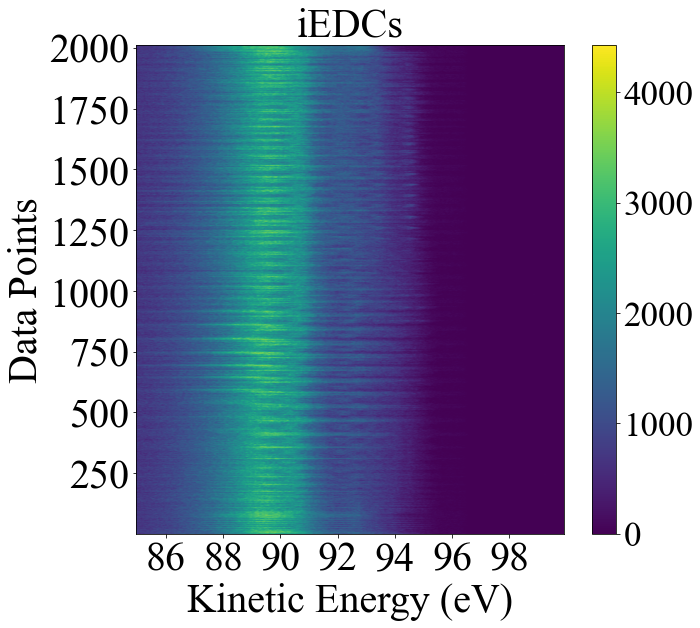

In [13]:
iEDCs = np.sum(iARPESs_cluster, axis = 2).reshape(iARPESs_cluster.shape[0], en) 
fig = plt.figure(figsize=(10,9))
plt.rcParams['font.family'] = 'Times New Roman'
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs, extent = [eng_ini, eng_end, 1, iARPESs_cluster.shape[0]], aspect = 0.0085)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("iEDCs",fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
fig = plt.gcf()
plt.show()
fig.savefig('plots/iEDCs_clusterMoS2.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/iEDCs_clusterMoS2.png', dpi=300, bbox_inches='tight')

### - SSE curve

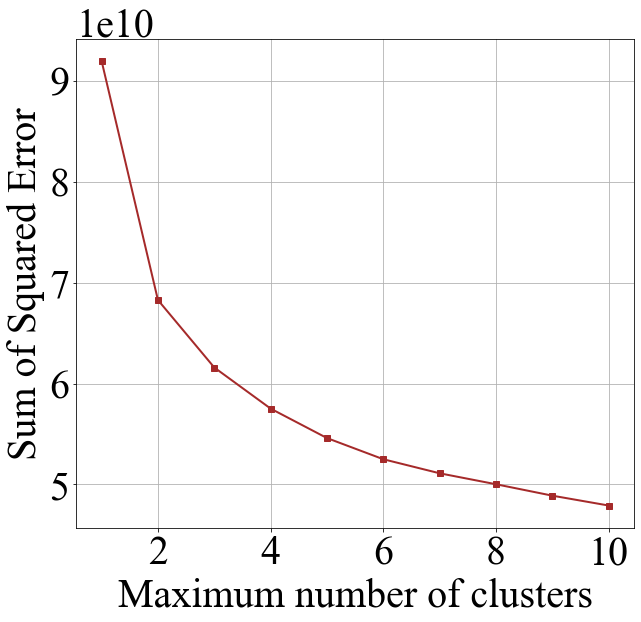

In [14]:
max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(iEDCs)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk
    
fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig('plots/SSE_MoS2.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/SSE_MoS2.png', dpi=300, bbox_inches='tight')

### - Check the clustering result of n=2,3,4 and calculate the performance metrics

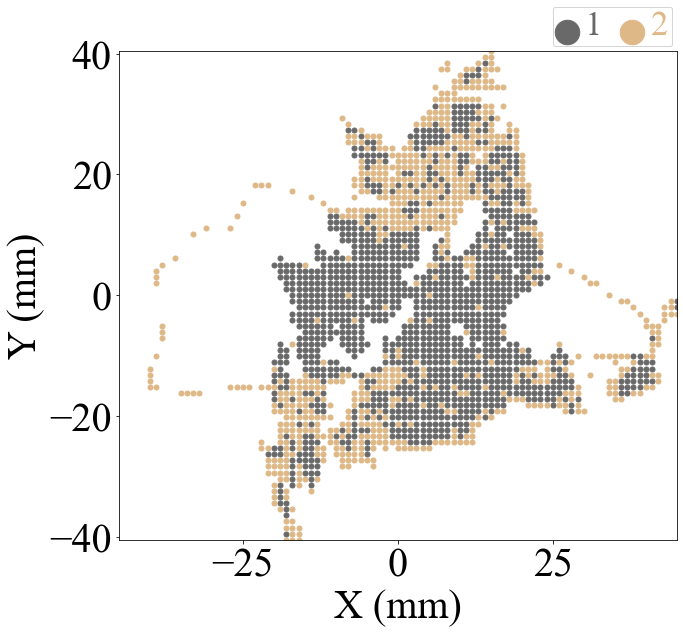

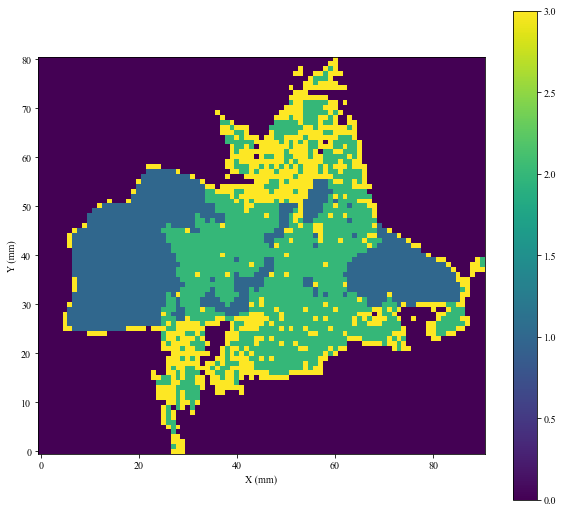

Overall Accuracy:  0.7940715405443922
Accuracy, Precision, Recall and F1 of Au:  0.9651592062759575 0.968287037037037 0.9966642840123898 0.9822707526124222
Accuracy, Precision, Recall and F1 of BN:  0.9133771929824561 0.9585730724971231 0.9509132420091324 0.9547277936962751
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.2926439232409382 0.48455428067078554 0.42492260061919507 0.45278350515463917
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.007415254237288136 0.010071942446043165 0.02734375 0.014721345951629864
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.435719115347328 0.4842972665301978 0.4799687753281434 0.48090067948299325


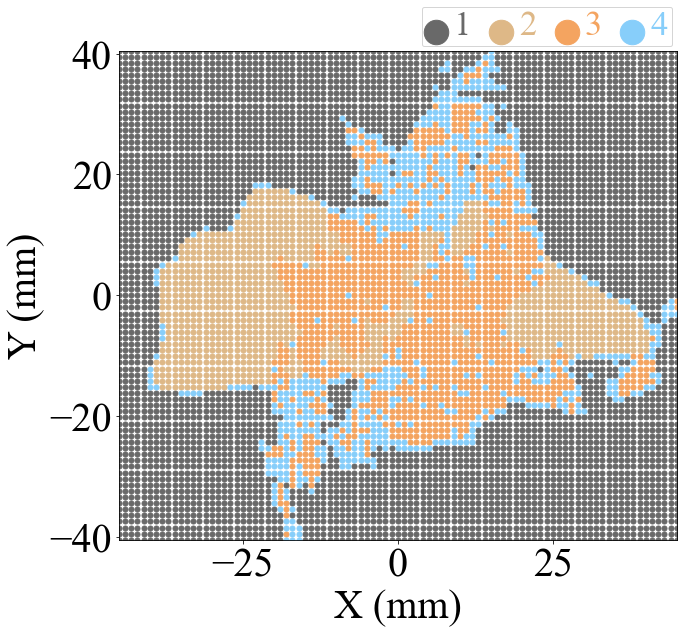

In [15]:
nk = 2
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={0:1, 1:0})

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1]], axis=0)
calculate_accuracy("Accuracy of nk = {}: ".format(nk), label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'plots/clustering_result_MoS2_{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots/clustering_result_MoS2_{nk}.png', dpi=300, bbox_inches='tight')

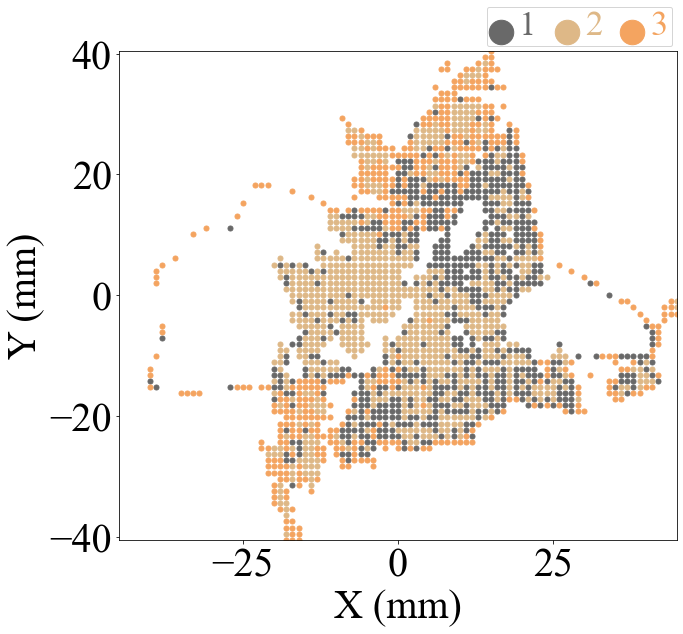

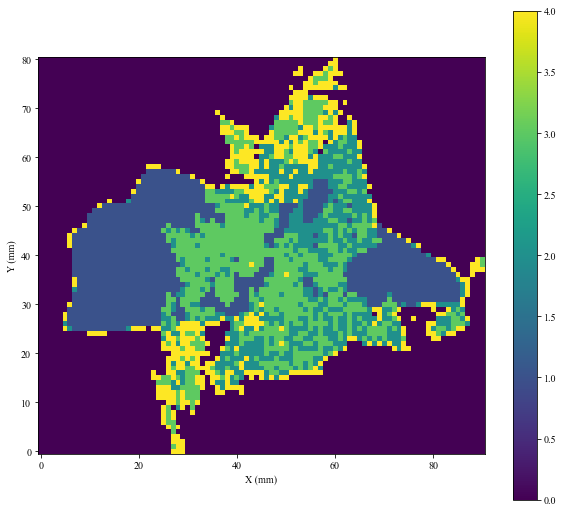

Overall Accuracy:  0.8030497363545674
Accuracy, Precision, Recall and F1 of Au:  0.9651592062759575 0.968287037037037 0.9966642840123898 0.9822707526124222
Accuracy, Precision, Recall and F1 of BN:  0.9133771929824561 0.9585730724971231 0.9509132420091324 0.9547277936962751
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.26383265856950067 0.6729776247848537 0.3026315789473684 0.4175120128136679
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.2725060827250608 0.28354430379746837 0.875 0.42829827915869984
Accuracy, Precision, Recall and F1 of m-MoS2:  0.004711425206124852 0.0087527352297593 0.010101010101010102 0.009378663540445486
marco averaging:  0.48391731315182007 0.5784269546692482 0.6270620230139802 0.5584375003643022


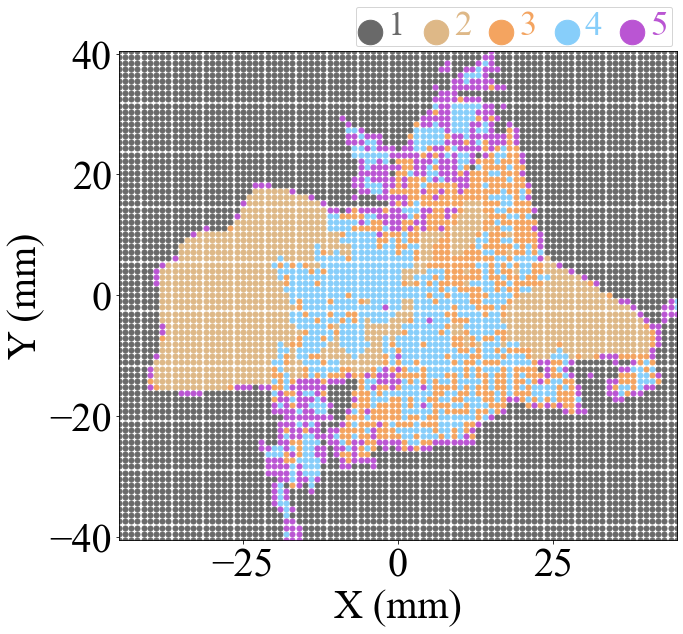

In [16]:
nk = 3
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={2:0, 1:1, 0:2})

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2]], axis=0)
calculate_accuracy("Accuracy of nk = {}: ".format(nk), label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'plots/clustering_result_MoS2_{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots/clustering_result_MoS2_{nk}.png', dpi=300, bbox_inches='tight')

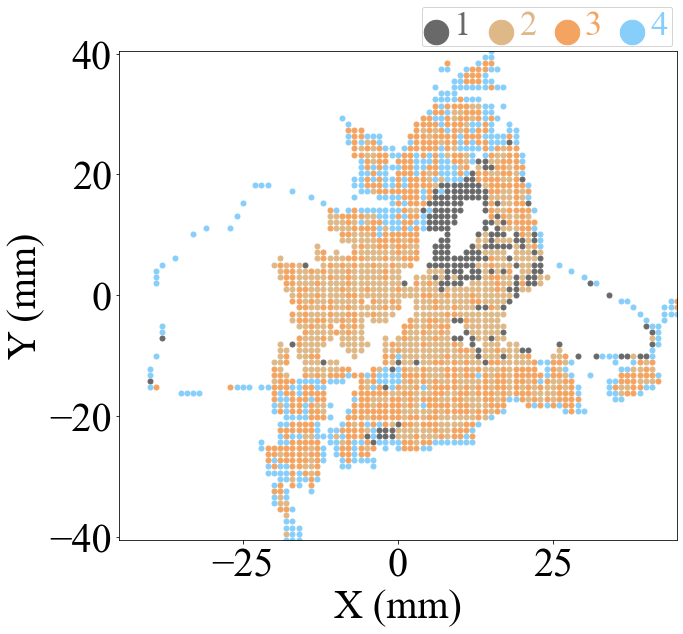

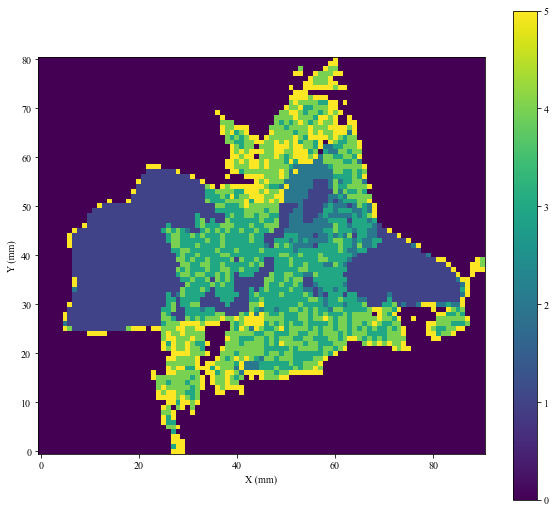

Overall Accuracy:  0.7558785805899957
Accuracy, Precision, Recall and F1 of Au:  0.9651592062759575 0.968287037037037 0.9966642840123898 0.9822707526124222
Accuracy, Precision, Recall and F1 of BN:  0.9133771929824561 0.9585730724971231 0.9509132420091324 0.9547277936962751
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.04329004329004329 0.38961038961038963 0.04643962848297214 0.08298755186721991
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.24335664335664337 0.27488151658767773 0.6796875 0.391451068616423
Accuracy, Precision, Recall and F1 of m-MoS2:  0.05389221556886228 0.08181818181818182 0.13636363636363635 0.10227272727272728
marco averaging:  0.44381506029479245 0.5346340395100818 0.5620136581736261 0.5027419788130134


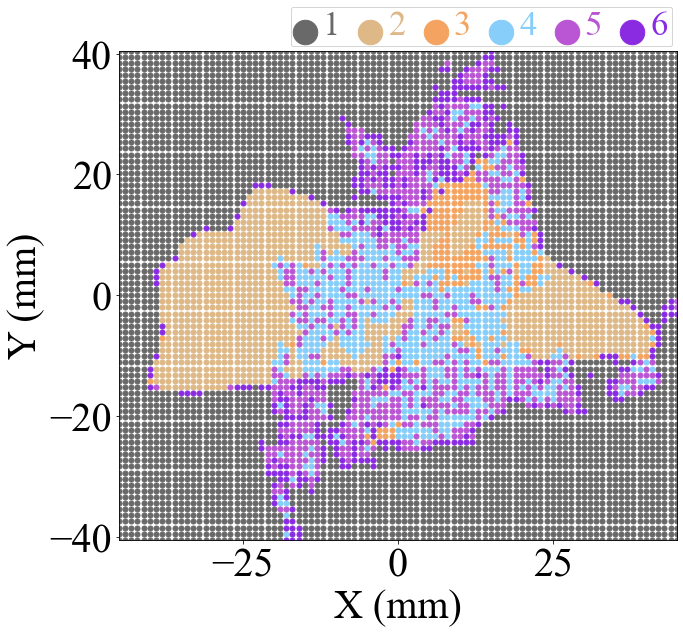

In [17]:
nk = 4
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={1:3, 2:1, 0:2, 3:0})

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2], new_km_results_of_chosen_cluster[3]], axis=0)
calculate_accuracy("Accuracy of nk = {}: ".format(nk), label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2], x_list[3]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2], y_list[3]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'plots/clustering_result_MoS2_{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots/clustering_result_MoS2_{nk}.png', dpi=300, bbox_inches='tight')

## iEDCs K-means clustering on the data of MoS2
### - based on a small analysis range 92 - 96 eV and -15 - 5deg

In [18]:
# Obtain the index chosen 
def get_location_in_iARPESArray_from_iARPESRange(ang_left,ang_right,eng_left,eng_right,ang,eng):
    arr = np.array(ang)
    condition = arr < ang_left
    if not np.any(condition):
        LR_col = 0
    else:
        indexes = np.where(condition)
        LR_col = indexes[0][-1]

    condition = arr > ang_right
    if not np.any(condition):
        RR_col = len(ang)-1
    else:
        indexes = np.where(condition)
        RR_col = indexes[0][0]
   
    arr = np.array(eng)
    condition = arr < eng_left
    if not np.any(condition):
        LR_row = 0
    else:
        indexes = np.where(condition)
        LR_row = indexes[0][-1]

    condition = arr > eng_right
    if not np.any(condition):
        RR_row = len(eng)-1
    else:
        indexes = np.where(condition)
        RR_row = indexes[0][0]
    
    #print("The range of angle is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(ang[LR_col],LR_col,ang[RR_col],RR_col,LR_col+1,ang[LR_col+1],RR_col-1,ang[RR_col-1]))
    #print("The range of energy is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(eng[LR_row],LR_row,eng[RR_row],RR_row,LR_row+1,eng[LR_row+1],RR_row-1,eng[RR_row-1]))
    
    return LR_col,RR_col,LR_row,RR_row

In [19]:
def get_iEDCs_of_one_range(angstart, angend,engstart, engend,iARPESs_chosen,ang,eng):  
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angstart,angend,engstart,engend,ang,eng)
    print(LR_col,RR_col,LR_row,RR_row)
    iARPESs_of_one_range = iARPESs_chosen[:,LR_row:RR_row+1,LR_col:RR_col+1]

    iEDCs_of_one_range = np.sum(iARPESs_of_one_range, axis = 2).reshape(iARPESs_of_one_range.shape[0],iARPESs_of_one_range.shape[1]) 
    
    return iEDCs_of_one_range

In [20]:
engstart = 92
engend = 96
angstart = -15
angend = 5

5 30 417 656


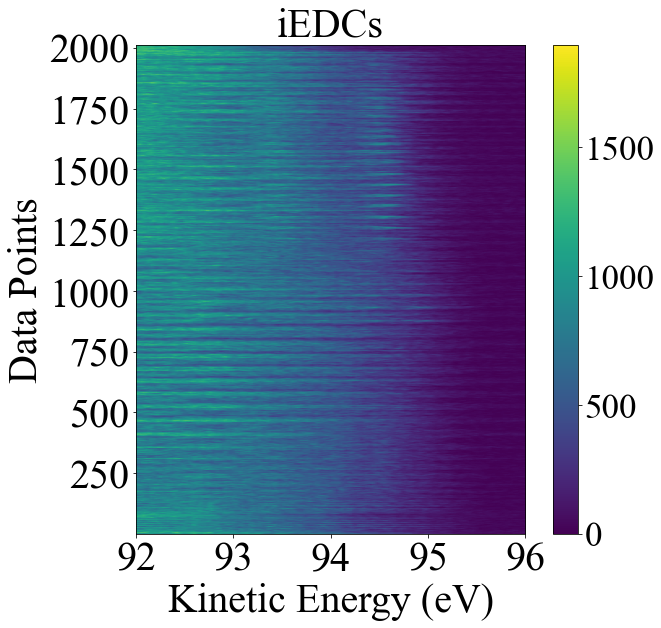

In [21]:
iEDCs = get_iEDCs_of_one_range(angstart, angend,engstart, engend,iARPESs_cluster,ang,eng)

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs, extent = [engstart, engend, 1, iARPESs_cluster.shape[0]], aspect = 0.0025)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("iEDCs",fontsize=fontsize1)
plt.xticks(np.arange(engstart, engend+1,1))
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.gcf()
plt.show()
fig.savefig('plots/iEDCs_clusterMoS2_smallregion.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/iEDCs_clusterMoS2_smallregion.png', dpi=300, bbox_inches='tight')

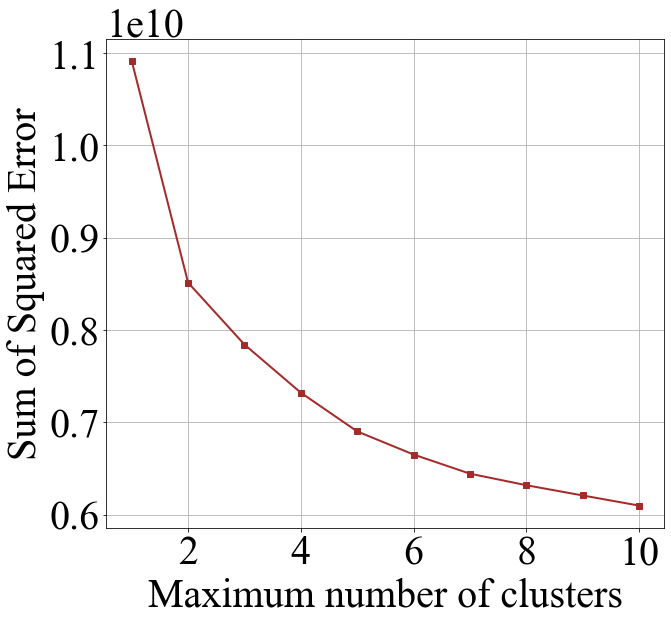

In [22]:
max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(iEDCs)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig('plots/SSE_MoS2_smallregion.pdf', dpi=300, bbox_inches='tight')
fig.savefig('plots/SSE_MoS2_smallregion.png', dpi=300, bbox_inches='tight')



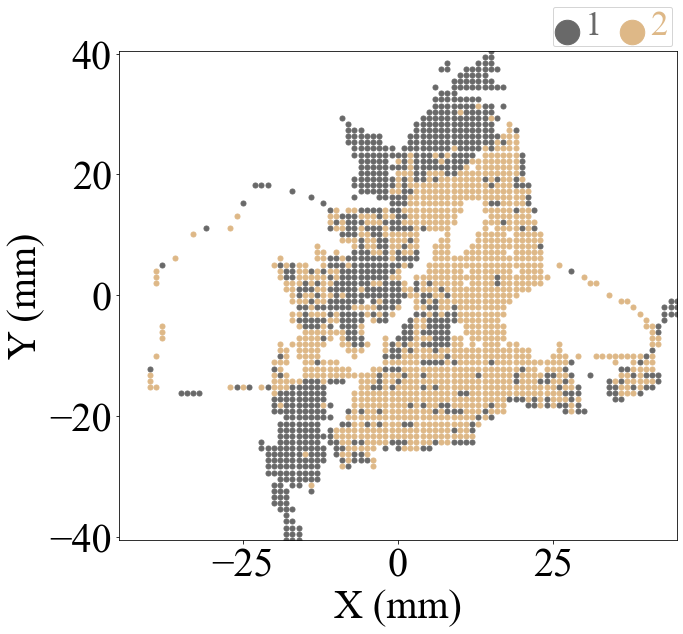

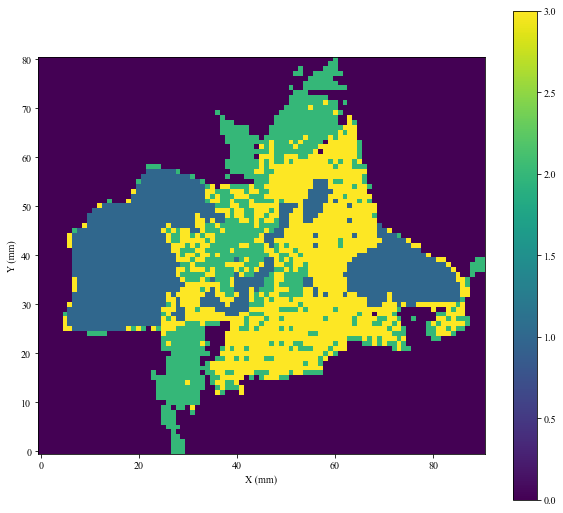

Overall Accuracy:  0.8127404873877726
Accuracy, Precision, Recall and F1 of Au:  0.9651592062759575 0.968287037037037 0.9966642840123898 0.9822707526124222
Accuracy, Precision, Recall and F1 of BN:  0.9133771929824561 0.9585730724971231 0.9509132420091324 0.9547277936962751
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.38271604938271603 0.7045454545454546 0.45588235294117646 0.5535714285714286
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.08521739130434783 0.09879032258064516 0.3828125 0.15705128205128208
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.4692939679890955 0.5460391773320519 0.5572544757925397 0.5295242513862816


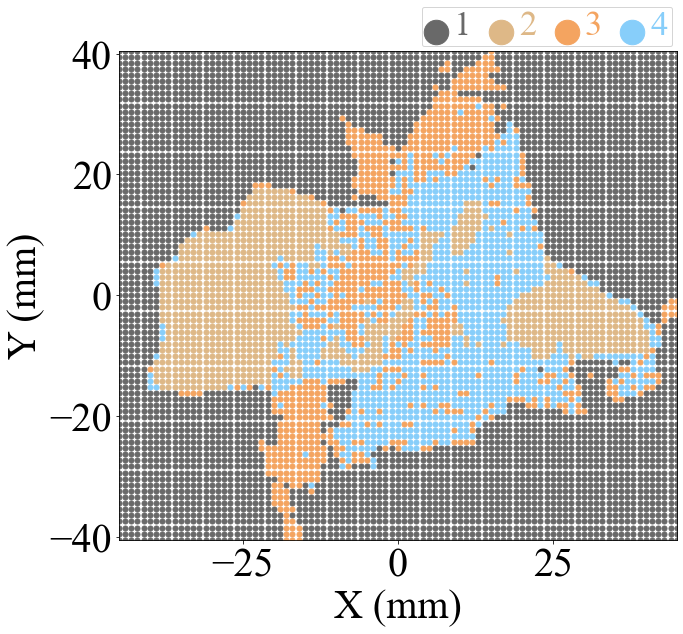

In [23]:
nk = 2
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={0:1, 1:0})

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1]], axis=0)
calculate_accuracy("Small Range, Accuracy of nk = {}: ".format(nk), label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'plots/clustering_result_MoS2_{nk}_smallregion.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots/clustering_result_MoS2_{nk}_smallregion.png', dpi=300, bbox_inches='tight')

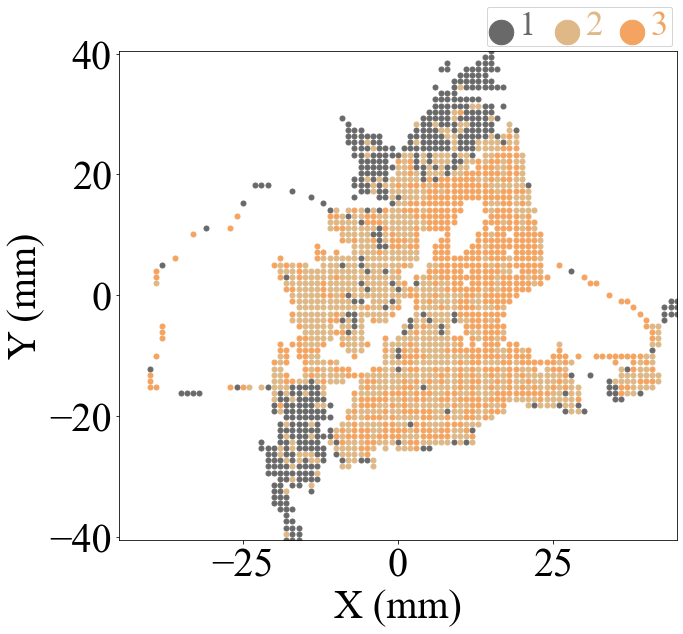

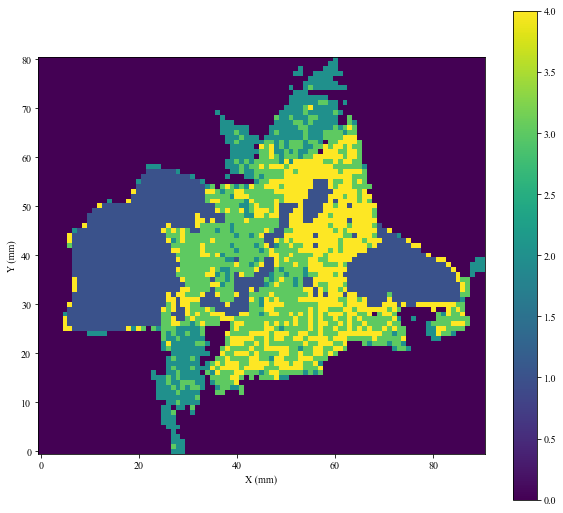

Overall Accuracy:  0.8292717685620635
Accuracy, Precision, Recall and F1 of Au:  0.9651592062759575 0.968287037037037 0.9966642840123898 0.9822707526124222
Accuracy, Precision, Recall and F1 of BN:  0.9133771929824561 0.9585730724971231 0.9509132420091324 0.9547277936962751
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.27958579881656803 0.863013698630137 0.29256965944272445 0.4369942196531792
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.2415795586527294 0.25584255842558423 0.8125 0.38914873713751164
Accuracy, Precision, Recall and F1 of m-MoS2:  0.28703703703703703 0.37608318890814557 0.547979797979798 0.44604316546762596
marco averaging:  0.5373477587529496 0.6843599110996054 0.7201253966888089 0.6418369337134028


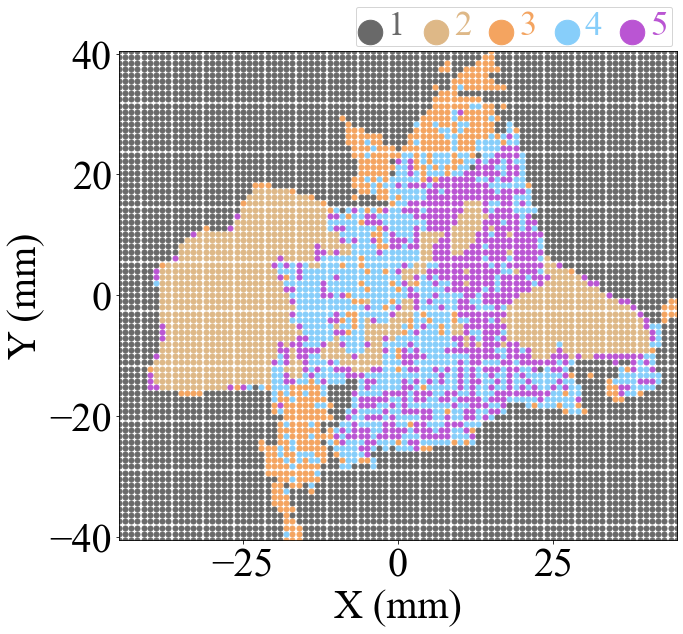

In [24]:
nk = 3
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={0:1, 1:0, 2:2})

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2]], axis=0)
calculate_accuracy("Small Range, Accuracy of nk = {}: ".format(nk), label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'plots/clustering_result_MoS2_{nk}_smallregion.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots/clustering_result_MoS2_{nk}_smallregion.png', dpi=300, bbox_inches='tight')

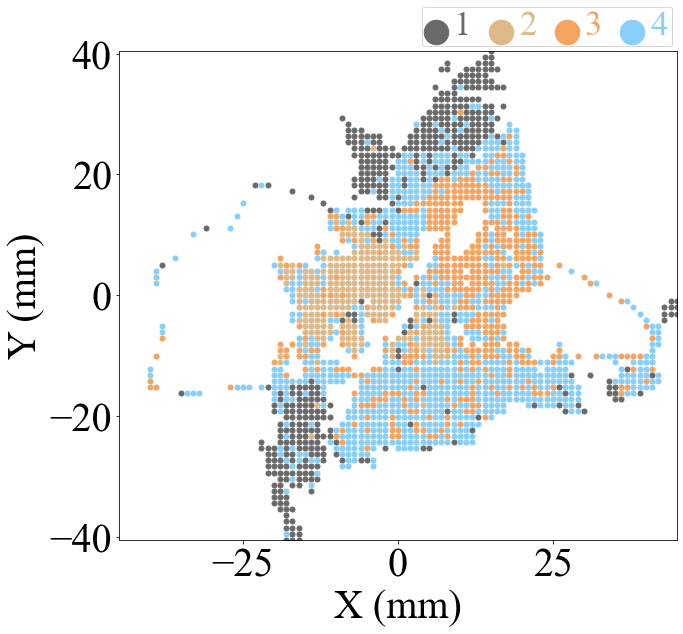

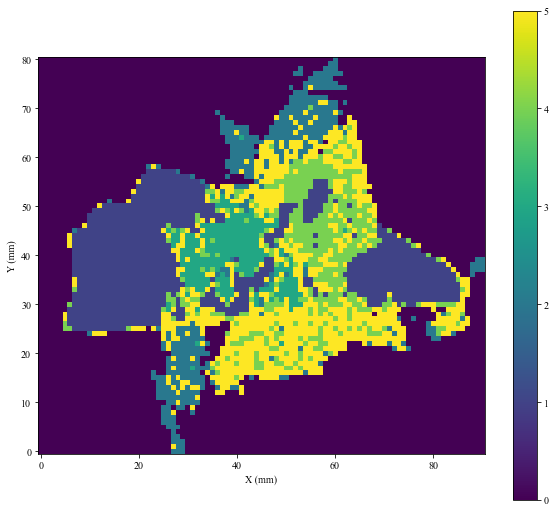

Overall Accuracy:  0.8252814593130967
Accuracy, Precision, Recall and F1 of Au:  0.9651592062759575 0.968287037037037 0.9966642840123898 0.9822707526124222
Accuracy, Precision, Recall and F1 of BN:  0.9133771929824561 0.9585730724971231 0.9509132420091324 0.9547277936962751
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.29638009049773756 0.9203747072599532 0.3041795665634675 0.4572425828970332
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.6302250803858521 0.7808764940239044 0.765625 0.7731755424063116
Accuracy, Precision, Recall and F1 of m-MoS2:  0.3069306930693069 0.4696969696969697 0.4696969696969697 0.4696969696969697
marco averaging:  0.622414452642262 0.8195616561029974 0.697415812456392 0.7274227282618024


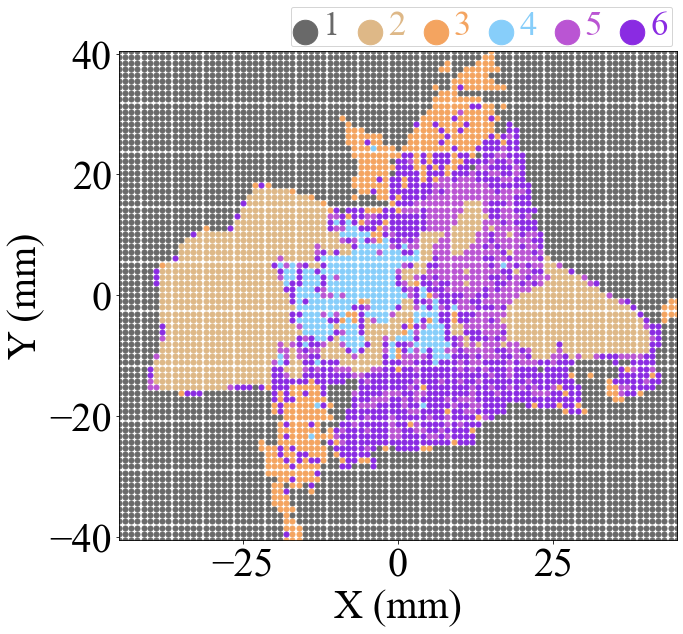

In [25]:
nk = 4
result,fig,x_list, y_list, new_km_results_of_chosen_cluster = clustering_and_visualization(nk,iEDCs,x_cluster,y_cluster,km_results_of_chosen_cluster,label_mapping={0:0,2:1,1:2,3:3})

label_all = np.sum([km_results_of_each_cluster[0], km_results_of_each_cluster[1], new_km_results_of_chosen_cluster[0], new_km_results_of_chosen_cluster[1], new_km_results_of_chosen_cluster[2], new_km_results_of_chosen_cluster[3]], axis=0)
calculate_accuracy("Small Range, Accuracy of nk = {}: ".format(nk), label_all, label_mapping = None)

x_of_each_cluster = [x_nk3[0], x_nk3[1], x_list[0], x_list[1], x_list[2], x_list[3]]
y_of_each_cluster = [y_nk3[0], y_nk3[1], y_list[0], y_list[1], y_list[2], y_list[3]]
fig = clustering_and_visualization_alldata(x_of_each_cluster, y_of_each_cluster)
fig.savefig(f'plots/clustering_result_MoS2_{nk}_smallregion.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots/clustering_result_MoS2_{nk}_smallregion.png', dpi=300, bbox_inches='tight')